In [ ]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import time as dt_time
from datetime import datetime

import numpy as np
import pandas as pd

import os
print(os.getcwd())

In [ ]:
# specify start_time as the beginning of today
now = datetime.now()
t0 = datetime.combine(now.date(), dt_time(6, 0, 0, 0))
start_time=t0
#start_time = datetime.combine(now.date(), datetime.min.time())

# --------- Create Random Scenario --------------
# Specify results saving path
path = './content/drive/MyDrive/Colab Notebooks'

df=pd.read_csv('vpatient_params.csv')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from simglucose.simulation.scenario import Action, Scenario
import numpy as np
from scipy.stats import truncnorm
from datetime import datetime
import logging

logger = logging.getLogger(__name__)


class BatchRandomScenario(Scenario):
    def __init__(self, start_time, seed=None):
        Scenario.__init__(self, start_time=start_time)
        self.seed = seed

    def get_action(self, t):
        # t must be datetime.datetime object
        delta_t = t - datetime.combine(t.date(), datetime.min.time())
        t_sec = delta_t.total_seconds()

        if t_sec < 1:
            logger.info('Creating new one day scenario ...')
            self.scenario = self.create_scenario()

        t_min = np.floor(t_sec / 60.0)

        if t_min in self.scenario['meal']['time']:
            logger.info('Time for meal!')
            idx = self.scenario['meal']['time'].index(t_min)
            return Action(meal=self.scenario['meal']['amount'][idx])
        else:
            return Action(meal=0)

    def create_scenario(self):
        scenario = {'meal': {'time': [], 'amount': []}}

        # Probability of taking each meal
        # [breakfast, snack1, lunch, snack2, dinner, snack3]
        prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
        time_lb = np.array([5, 9, 10, 14, 16, 20]) * 60
        time_ub = np.array([9, 10, 14, 16, 20, 23]) * 60
        time_mu = np.array([7, 9.5, 12, 15, 18, 21.5]) * 60
        time_sigma = np.array([60, 30, 60, 30, 60, 30])
        amount_mu = [10, 3, 20, 3, 20, 3]
        amount_sigma = [3, 1, 3, 1, 3, 1]

        for p, tlb, tub, tbar, tsd, mbar, msd in zip(prob, time_lb, time_ub,
                                                     time_mu, time_sigma,
                                                     amount_mu, amount_sigma):
            if self.random_gen.rand() < p:
                tmeal = np.round(
                    truncnorm.rvs(a=(tlb - tbar) / tsd,
                                  b=(tub - tbar) / tsd,
                                  loc=tbar,
                                  scale=tsd,
                                  random_state=self.random_gen))
                scenario['meal']['time'].append(tmeal)
                scenario['meal']['amount'].append(
                    max(round(self.random_gen.normal(mbar, msd)), 0))

        return scenario

    def reset(self):
        self.random_gen = np.random.RandomState(self.seed)
        self.scenario = self.create_scenario()

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed
        self.reset()



# SIMULATE A SINGLE PATIENT TO TEST EVERYTHING WORKS

## 1. Setup patient loading its parameters from file
## 2. Setup CGM sensor and pump models
## 3. Setup meal pattern (custom or randomized)
## 4. Simulate the CGM measures

In [ ]:
##################################################################################################################
# 1. Setup patient loading its parameters from file
##################################################################################################################
# Create a patient
patient = T1DPatient.withName('adolescent#001')
#add random variation to the Vg value to simulate more patients
patient._params.Vmx=patient._params.Vmx#+0.003*np.random.randn()


In [ ]:
##################################################################################################################
# 2. Setup CGM sensor and pump models
##################################################################################################################
# Creat sensor and insulin pump
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')

In [ ]:
##################################################################################################################
# 3. Setup custom meal pattern
# custom scenario is a list of tuples (time, meal_size)
##################################################################################################################
prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
base_t=[7, 10, 12.5, 16, 20, 22]
base_m = [10, 3, 20, 3, 20, 3]
sigma_m = [2, 1, 3, 1, 3, 1]
#base_t=[7,12,14,18,22]
#base_m=[45,70,15,80,10]
#base_m=[15,20,3,26,3]
max_days=10
scen=[]

for d in range(max_days):
    for i in range(6):
        pmeal=np.random.uniform()
        if(pmeal<prob[i]):
            tm=(base_t[i]+(np.random.uniform()-0.5)*2)*60+d*24*60
            vm=max(0,base_m[i]+sigma_m[i]*np.random.randn())
            scen.append((tm,vm))

#scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10), (7+24, 45), (12+24, 70), (16+24, 15), (18+24, 80), (23+24, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)

In [ ]:
scenario.scenario

[(392.3647450301091, 10.179469315297503),
 (544.0686633473276, 2.1955983182645245),
 (808.235228021123, 17.285239209008335),
 (1140.762908747069, 19.58825010949772),
 (1863.179238079398, 13.651041663080756),
 (2157.6837314596864, 22.05980168057038),
 (2664.3821818565157, 20.522482981355505),
 (3329.7642664763107, 8.2964562128391),
 (3614.1089942861013, 14.249380899649932),
 (4067.9561549220316, 23.876804913777914),
 (4715.502223444721, 8.480357627380693),
 (4880.506322076723, 1.6871179169645054),
 (5120.097734058059, 20.20524341720144),
 (5474.411189107432, 18.004697022505677),
 (6133.870119719452, 5.896136186887017),
 (6316.947846844136, 4.205531345028389),
 (6526.522982185618, 17.82131614488878),
 (6952.577868845388, 20.15516848270505),
 (7577.3895326634, 10.176278292185078),
 (7969.629997241681, 22.49533591465836),
 (8358.083129730665, 20.87816865695424),
 (8477.811249477289, 1.5505420261606675),
 (9016.199638426891, 9.393484454668602),
 (9425.017820301422, 20.606685286820397),
 (98

In [ ]:
##################################################################################################################
# 3. Setup custom meal pattern
# custom scenario is a list of tuples (time, meal_size)
##################################################################################################################
max_days=10

from simglucose.simulation.scenario_gen import RandomScenario
sim_time = timedelta(days=max_days)
now = datetime.now()

#scenario=RandomScenario(start_time=t0, seed=42)
scenario=BatchRandomScenario(start_time=t0, seed=42)
#m = []
#T = []
#
#t = t0
#while t < t0 + sim_time:
#    action = scenario.get_action(t)
#    m.append(action.meal)
#    T.append(t)
#    t += timedelta(minutes=1)

In [ ]:
np.array(scenario.scenario['meal']['time'])/60

array([ 8.48333333,  9.18333333, 13.03333333, 15.81666667, 17.25      ])

Process ID: 921
Simulation starts ...
Simulation Completed!


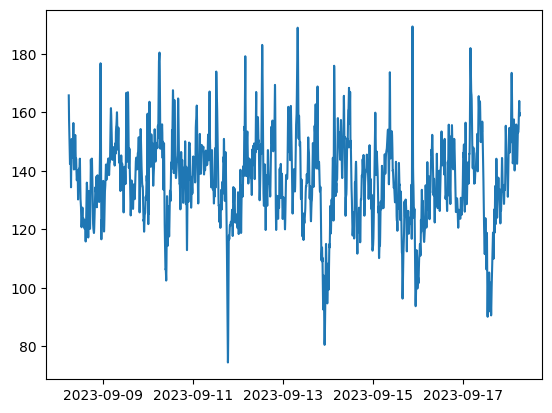

In [ ]:
##################################################################################################################
# 4. Simulate the CGM measures
##################################################################################################################

env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s2 = SimObj(env, controller, timedelta(days=max_days), animate=False, path=path)
results2 = sim(s2)

import matplotlib.pyplot as plt
plt.plot(results2.CGM)

# New Code

In [ ]:
path = './content'

df=pd.read_csv('vpatient_params.csv')

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load target parameter data
vpatient_params=pd.read_csv('vpatient_params.csv')
df1=pd.read_excel('adolescent.xla')

# Load your CGM, bolus, meal data (assuming they are already loaded)
# For demonstration, let's assume you've loaded them into 'cgm_data', 'bolus_data', and 'meal_data'
cgm =df1[['CGM']]
bolus=df1[['insulin']]
meal=df1[['HBGI']]
# Concatenate the arrays along the columns (axis=1)
df2 = np.concatenate((cgm, bolus, meal), axis=1)


In [ ]:
vpatient_params

In [ ]:
vpatient = vpatient_params[['Vmx', 'kabs', 'kmax', 'kmin', 'ka2', 'ka1', 'kd', 'd']]


In [ ]:
vpatient1 =vpatient_params[['Vmx', 'kabs', 'kmax', 'kmin','ka2', 'ka1', 'kd', 'kp3', 'CL']]

In [ ]:
input_data= df2

In [ ]:
 vpatient_params.values

array([['adolescent#001', 1, 0, ..., 93.2258828462, 11.5048231338, 0],
       ['adolescent#002', 2, 0, ..., 47.1721248798, 4.19657924407, 0],
       ['adolescent#003', 3, 0, ..., 81.3429092974, 6.58878876028, 0],
       ...,
       ['child#008', 88, 0, ..., 119.914029849, 5.46619598839, 0],
       ['child#009', 89, 0, ..., 31.539253961, 8.92304270886, 0],
       ['child#010', 100, 0, ..., 54.4625955612, 4.82258449688, 0]],
      dtype=object)

In [ ]:
print("Shape of input_data:", input_data.shape)
print("Shape of vpatients:", vpatient.shape)


Shape of input_data: (30, 3)
Shape of vpatients: (30, 8)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(vpatient1, cgm, test_size=0.2, random_state=42)

# Standardize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)

# Convert y_train DataFrame to a NumPy array
y_train_array = np.array(y_train)

# Create PyTorch tensors for y_train
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Define a neural network model
class ParameterEstimationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ParameterEstimationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model
input_size = X_train_tensor.shape[1]  # Adjust this based on your input features
hidden_size = 64  # You can adjust this as well
output_size = 1  # Assuming you have a single output

model = ParameterEstimationModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss at every 10 epochs (or as needed)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation (you can modify this part for testing)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# You can now use y_pred for evaluation or further analysis


Epoch [10/100], Loss: 22140.1660
Epoch [20/100], Loss: 22071.0371
Epoch [30/100], Loss: 21999.4785
Epoch [40/100], Loss: 21923.7734
Epoch [50/100], Loss: 21842.4258
Epoch [60/100], Loss: 21754.0488
Epoch [70/100], Loss: 21657.3184
Epoch [80/100], Loss: 21550.9082
Epoch [90/100], Loss: 21434.0996
Epoch [100/100], Loss: 21305.7598


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Evaluation (same as before)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Calculate Mean Absolute Error (MAE) for each output dimension
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

# Calculate Root Mean Squared Error (RMSE) for each output dimension
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))

# Calculate R-squared (R2) for each output dimension
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print the metrics for each output dimension
for i, (mae_i, rmse_i, r2_i) in enumerate(zip(mae, rmse, r2)):
    print(f'Output Dimension {i+1}:')
    print(f'Mean Absolute Error (MAE): {mae_i:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse_i:.4f}')
    print(f'R-squared (R2): {r2_i:.4f}')
    print('---')




Output Dimension 1:
Mean Absolute Error (MAE): 146.9325
Root Mean Squared Error (RMSE): 146.9365
R-squared (R2): -11900.4849
---


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
# ...

# Evaluation (same as before)
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Calculate Mean Absolute Error (MAE) for each output dimension
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

# Calculate Root Mean Squared Error (RMSE) for each output dimension
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))

# Calculate R-squared (R2) for each output dimension
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Calculate Mean Percentage Error (MPE)
mpe = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

# Calculate Normalized RMSE (NRMSE)
range_y_test = y_test.max() - y_test.min()
nrmse = rmse / range_y_test

# Calculate Explained Variance Score (EVS)
evs = explained_variance_score(y_test, y_pred)

# Calculate Max Error
max_err = max_error(y_test, y_pred)

# Print the metrics for each output dimension
for i, (mae_i, rmse_i, r2_i) in enumerate(zip(mae, rmse, r2)):
    print(f'Output Dimension {i+1}:')
    print(f'Mean Absolute Error (MAE): {mae_i:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse_i:.4f}')
    print(f'R-squared (R2): {r2_i:.4f}')
    print(f'Mean Percentage Error (MPE): {mpe:.4f}%')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')
    print(f'Normalized RMSE (NRMSE): {nrmse[i]:.4f}')
    print(f'Explained Variance Score (EVS): {evs:.4f}')
    print(f'Max Error: {max_err:.4f}')
    print('---')

    import numpy as np




Output Dimension 1:
Mean Absolute Error (MAE): 146.9325
Root Mean Squared Error (RMSE): 146.9365
R-squared (R2): -11900.4849
Mean Percentage Error (MPE): 98.2245%
Mean Absolute Percentage Error (MAPE): 98.2245%
Normalized RMSE (NRMSE): 40.6650
Explained Variance Score (EVS): 0.3547
Max Error: 148.1713
---


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(vpatient1, cgm, test_size=0.2, random_state=42)

# Standardize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_array = np.array(y_train)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Define a neural network model
class ParameterEstimationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ParameterEstimationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = 1

model = ParameterEstimationModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100

# Specify the epochs at which you want to calculate metrics
epochs_to_calculate_metrics = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss at every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Check if the current epoch is in the list of epochs to calculate metrics
    if (epoch + 1) in epochs_to_calculate_metrics:
        # Evaluation for the current epoch
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)

        # Calculate and print the metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        evs = explained_variance_score(y_test, y_pred)
        max_err = max_error(y_test, y_pred)

        print(f'Metrics at Epoch {epoch + 1}:')
        print(f'Mean Absolute Error (MAE): {mae:.4f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
        print(f'R-squared (R2): {r2:.4f}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')
        print(f'Explained Variance Score (EVS): {evs:.4f}')
        print(f'Max Error: {max_err:.4f}')
        print('---')

    # Set the model back to training mode
    model.train()

# After training, you can use the final model and metrics for further analysis


Epoch [1/100], Loss: 22266.6387
Epoch [2/100], Loss: 22260.1426
Epoch [3/100], Loss: 22253.6465
Epoch [4/100], Loss: 22247.1406
Epoch [5/100], Loss: 22240.6328
Epoch [6/100], Loss: 22234.1230
Epoch [7/100], Loss: 22227.6094
Epoch [8/100], Loss: 22221.0938
Epoch [9/100], Loss: 22214.5762
Epoch [10/100], Loss: 22208.0566
Metrics at Epoch 10:
Mean Absolute Error (MAE): 149.2320
Root Mean Squared Error (RMSE): 149.2377
R-squared (R2): -12276.1781
Mean Absolute Percentage Error (MAPE): 99.7602%
Explained Variance Score (EVS): 0.0659
Max Error: 150.1810
---
Epoch [11/100], Loss: 22201.5312
Epoch [12/100], Loss: 22195.0078
Epoch [13/100], Loss: 22188.4746
Epoch [14/100], Loss: 22181.9297
Epoch [15/100], Loss: 22175.3730
Epoch [16/100], Loss: 22168.8047
Epoch [17/100], Loss: 22162.2207
Epoch [18/100], Loss: 22155.6172
Epoch [19/100], Loss: 22148.9980
Epoch [20/100], Loss: 22142.3594
Metrics at Epoch 20:
Mean Absolute Error (MAE): 148.9789
Root Mean Squared Error (RMSE): 148.9841
R-squared (R2)

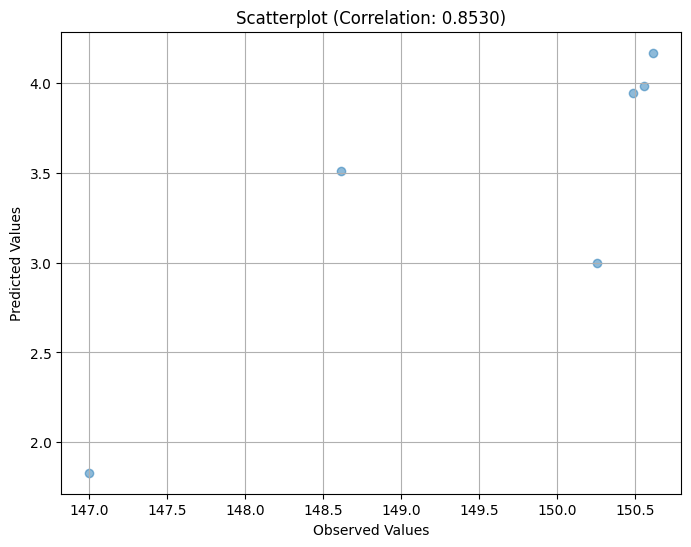

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
import matplotlib.pyplot as plt

# ... (Rest of your code up to model training) ...

# After training, you can use the final model and metrics for further analysis

# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Convert predicted values and ground truth to NumPy arrays
y_pred = y_pred.numpy()
y_test_array = np.array(y_test)

# Reshape the arrays to have the same dimensions
y_pred = y_pred.reshape(-1)
y_test_array = y_test_array.reshape(-1)

# Calculate the correlation coefficient between predicted and observed values
correlation_coefficient = np.corrcoef(y_pred, y_test_array)[0, 1]

# Create a scatterplot of predicted vs. observed values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_array, y_pred, alpha=0.5)
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title(f"Scatterplot (Correlation: {correlation_coefficient:.4f})")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error

# Assuming you have 1D continuous input data
X_train, X_test, y_train, y_test = train_test_split(vpatient1, cgm, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
import numpy as np

# Print shape and first few rows of X_train_scaled
print("X_train_scaled shape:", X_train_scaled.shape)
print("First few rows of X_train_scaled:")
print(X_train_scaled[:5, :])

# Check for NaN values in X_train_scaled before imputation
nan_indices_before = np.where(np.isnan(X_train_scaled))
print("Number of NaN values in X_train_scaled before imputation:", len(nan_indices_before[0]))
import numpy as np
from sklearn.impute import SimpleImputer
# Handle missing values in the features (X_train_scaled)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_scaled)
# Check for NaN values in X_train_scaled after imputation
nan_indices_after = np.where(np.isnan(X_train_scaled))
print("Number of NaN values in X_train_scaled after imputation:", len(nan_indices_after[0]))
# Drop rows with NaN values
X_train_scaled_cleaned = X_train_scaled[~np.isnan(X_train_scaled).any(axis=1)]
y_train_cleaned = y_train[~np.isnan(X_train_scaled).any(axis=1)]





X_train_scaled shape: (24, 9)
First few rows of X_train_scaled:
[[ 1.44484834 -0.12793786  1.61356047  0.82237858  1.58505227  0.56665581
  -0.57356721  0.74027459 -1.19939462]
 [ 1.30395588  0.51770452 -1.88169649  0.690722    0.3303455  -0.17649935
   1.96220361 -0.62861375 -0.99664365]
 [ 0.23485255 -0.10296968 -0.01953615 -0.74109742 -0.45157321  0.12076271
  -0.15093874 -0.16218169  0.99825332]
 [ 0.22838207 -0.40590625 -1.7062638  -0.18129388 -1.19712361 -1.06828554
   1.23769766  2.47065547  0.30360482]
 [-0.53066517  3.98892876 -1.07520678  3.35787743 -0.06970593 -0.54807693
  -0.81506919 -0.78997086 -0.36383254]]
Number of NaN values in X_train_scaled before imputation: 0
Number of NaN values in X_train_scaled after imputation: 0


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Reshape the input data for CNN
X_train_cnn = X_train_scaled_cleaned.reshape(X_train_scaled_cleaned.shape[0], X_train_scaled_cleaned.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Create a Convolutional Neural Network (CNN) model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
# Remove or adjust the pool_size as needed
cnn_model.add(MaxPooling1D(pool_size=1))  # You can also remove this line if needed
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1))
# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the CNN model
cnn_model.fit(X_train_cnn, y_train_cleaned, epochs=10, batch_size=32, verbose=1)

# Make predictions using the trained CNN model
cnn_predictions = cnn_model.predict(X_test_cnn)

# Calculate Mean Absolute Error (MAE) for CNN
cnn_mae = mean_absolute_error(y_test, cnn_predictions)
print(f'Mean Absolute Error (CNN): {cnn_mae}')

# Calculate Root Mean Squared Error (RMSE) for CNN
cnn_rmse = mean_squared_error(y_test, cnn_predictions, squared=False)
print(f'Root Mean Squared Error (CNN): {cnn_rmse}')




Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 22252.6738
Epoch 2/10
1/1 [==============================] - 0s 33ms/step - loss: 22214.3535
Epoch 3/10
1/1 [==============================] - 0s 28ms/step - loss: 22176.1348
Epoch 4/10
1/1 [==============================] - 0s 27ms/step - loss: 22137.5684
Epoch 5/10
1/1 [==============================] - 0s 42ms/step - loss: 22098.5723
Epoch 6/10
1/1 [==============================] - 0s 32ms/step - loss: 22059.5059
Epoch 7/10
1/1 [==============================] - 0s 45ms/step - loss: 22020.1738
Epoch 8/10
1/1 [==============================] - 0s 33ms/step - loss: 21979.9844
Epoch 9/10
1/1 [==============================] - 0s 38ms/step - loss: 21939.0000
Epoch 10/10
1/1 [==============================] - 0s 328ms/step
Mean Absolute Error (CNN): 147.91081921770555
Root Mean Squared Error (CNN): 147.91572767559433


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error

# Reshape the input data for CNN
X_train_cnn = X_train_scaled_cleaned.reshape(X_train_scaled_cleaned.shape[0], X_train_scaled_cleaned.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Create a Convolutional Neural Network (CNN) model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])))
# Remove or adjust the pool_size as needed
cnn_model.add(MaxPooling1D(pool_size=1))  # You can also remove this line if needed
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1))
# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Define a function to calculate metrics for a given model and data
def calculate_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    evs = explained_variance_score(y_test, predictions)
    max_err = max_error(y_test, predictions)
    return mae, rmse, r2, mape, evs, max_err

# Training loop
num_epochs = 100

# Specify the epochs at which you want to calculate metrics
epochs_to_calculate_metrics = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for epoch in range(num_epochs):
    # Train the CNN model for one epoch
    cnn_model.fit(X_train_cnn, y_train_cleaned, epochs=1, batch_size=32, verbose=0)

    # Check if the current epoch is in the list of epochs to calculate metrics
    if (epoch + 1) in epochs_to_calculate_metrics:
        # Calculate and print the metrics for the current epoch
        mae, rmse, r2, mape, evs, max_err = calculate_metrics(cnn_model, X_test_cnn, y_test)
        print(f'Metrics at Epoch {epoch + 1}:')
        print(f'Mean Absolute Error (MAE): {mae:.4f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
        print(f'R-squared (R2): {r2:.4f}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')
        print(f'Explained Variance Score (EVS): {evs:.4f}')
        print(f'Max Error: {max_err:.4f}')
        print('---')

# After training, you can use the final model and metrics for further analysis


1/1 [==============================] - 0s 123ms/step
Metrics at Epoch 10:
Mean Absolute Error (MAE): 148.3236
Root Mean Squared Error (RMSE): 148.3283
R-squared (R2): -12127.0082
Mean Absolute Percentage Error (MAPE): 99.1538%
Explained Variance Score (EVS): 0.2333
Max Error: 149.2912
---
1/1 [==============================] - 0s 40ms/step
Metrics at Epoch 20:
Mean Absolute Error (MAE): 146.6003
Root Mean Squared Error (RMSE): 146.6040
R-squared (R2): -11846.6815
Mean Absolute Percentage Error (MAPE): 98.0030%
Explained Variance Score (EVS): 0.3977
Max Error: 147.6654
---
1/1 [==============================] - 0s 23ms/step
Metrics at Epoch 30:
Mean Absolute Error (MAE): 144.1401
Root Mean Squared Error (RMSE): 144.1434
R-squared (R2): -11452.3178
Mean Absolute Percentage Error (MAPE): 96.3600%
Explained Variance Score (EVS): 0.4696
Max Error: 145.2486
---
1/1 [==============================] - 0s 26ms/step
Metrics at Epoch 40:
Mean Absolute Error (MAE): 140.6646
Root Mean Squared Error

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
import matplotlib.pyplot as plt

# ... (Rest of your code up to model training) ...

# After training, you can use the final model and metrics for further analysis

# Evaluate the model on the test data
y_pred = cnn_model.predict(X_test_cnn)

# Flatten the predicted and observed values
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Calculate the correlation coefficient between predicted and observed values
correlation_coefficient = np.corrcoef(y_pred, y_test)[0, 1]

# Create a scatterplot of predicted vs. observed values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title(f"Scatterplot (Correlation: {correlation_coefficient:.4f})")
plt.grid(True)
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error

# Reshape the input data for LSTM
X_train_lstm = X_train_scaled_cleaned.reshape(X_train_scaled_cleaned.shape[0], X_train_scaled_cleaned.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Create an LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(1))
# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Define a function to calculate metrics for a given model and data
def calculate_metrics(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    evs = explained_variance_score(y_test, predictions)
    max_err = max_error(y_test, predictions)
    return mae, rmse, r2, mape, evs, max_err

# Training loop
num_epochs = 100

# Specify the epochs at which you want to calculate metrics
epochs_to_calculate_metrics = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for epoch in range(num_epochs):
    # Train the LSTM model for one epoch
    lstm_model.fit(X_train_lstm, y_train_cleaned, epochs=1, batch_size=32, verbose=0)

    # Check if the current epoch is in the list of epochs to calculate metrics
    if (epoch + 1) in epochs_to_calculate_metrics:
        # Calculate and print the metrics for the current epoch
        mae, rmse, r2, mape, evs, max_err = calculate_metrics(lstm_model, X_test_lstm, y_test)
        print(f'Metrics at Epoch {epoch + 1}:')
        print(f'Mean Absolute Error (MAE): {mae:.4f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
        print(f'R-squared (R2): {r2:.4f}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')
        print(f'Explained Variance Score (EVS): {evs:.4f}')
        print(f'Max Error: {max_err:.4f}')
        print('---')

# After training, you can use the final LSTM model and metrics for further analysis


1/1 [==============================] - 0s 265ms/step
Metrics at Epoch 10:
Mean Absolute Error (MAE): 149.2124
Root Mean Squared Error (RMSE): 149.2180
R-squared (R2): -12272.9460
Mean Absolute Percentage Error (MAPE): 99.7471%
Explained Variance Score (EVS): 0.0708
Max Error: 150.3070
---
1/1 [==============================] - 0s 47ms/step
Metrics at Epoch 20:
Mean Absolute Error (MAE): 148.4336
Root Mean Squared Error (RMSE): 148.4387
R-squared (R2): -12145.0728
Mean Absolute Percentage Error (MAPE): 99.2268%
Explained Variance Score (EVS): 0.1619
Max Error: 149.4824
---
1/1 [==============================] - 0s 32ms/step
Metrics at Epoch 30:
Mean Absolute Error (MAE): 143.5084
Root Mean Squared Error (RMSE): 143.5436
R-squared (R2): -11357.1938
Mean Absolute Percentage Error (MAPE): 95.9342%
Explained Variance Score (EVS): -4.5629
Max Error: 146.3230
---
1/1 [==============================] - 0s 33ms/step
Metrics at Epoch 40:
Mean Absolute Error (MAE): 94.1287
Root Mean Squared Error

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.8 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error




In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error

# Load a pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  # You can choose different BERT variants
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Modify num_labels for your task

# Example data (replace with your own data)
texts = ["This is a positive sentence.", "This is a negative sentence."]
labels = [1, 0]  # Example binary labels (1 for positive, 0 for negative)

# Tokenize the input texts
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer(
        text,
        add_special_tokens=True,
        max_length=64,  # Modify as needed
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Create a DataLoader for batching
dataset = TensorDataset(input_ids, attention_masks, labels)
batch_size = 2  # Modify as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)  # Adjust learning rate as needed
num_epochs = 100  # Modify as needed

# Specify the epochs at which you want to calculate metrics
epochs_to_calculate_metrics = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        batch_input_ids, batch_attention_mask, batch_labels = batch
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    # Check if the current epoch is in the list of epochs to calculate metrics
    if (epoch + 1) in epochs_to_calculate_metrics:
        # After each epoch, estimate evaluation metrics on validation data
        model.eval()
        val_texts = ["This is a positive sentence for validation.", "This is a negative sentence for validation."]
        val_labels = [1, 0]  # Validation labels
        val_input_ids = []
        val_attention_masks = []

        for val_text in val_texts:
            val_encoded_dict = tokenizer(
                val_text,
                add_special_tokens=True,
                max_length=64,  # Modify as needed
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            val_input_ids.append(val_encoded_dict['input_ids'])
            val_attention_masks.append(val_encoded_dict['attention_mask'])

        val_input_ids = torch.cat(val_input_ids, dim=0)
        val_attention_masks = torch.cat(val_attention_masks, dim=0)
        val_labels = torch.tensor(val_labels)

        with torch.no_grad():
            val_outputs = model(val_input_ids, attention_mask=val_attention_masks)
            val_predictions = torch.argmax(val_outputs.logits, dim=1)

        # Calculate evaluation metrics on validation data
        mae = mean_absolute_error(val_labels, val_predictions)
        rmse = mean_squared_error(val_labels, val_predictions, squared=False)
        r2 = r2_score(val_labels, val_predictions)
        mape = mean_absolute_percentage_error(val_labels, val_predictions) * 100
        evs = explained_variance_score(val_labels, val_predictions)
        max_err = max_error(val_labels, val_predictions)

        print(f'Metrics at Epoch {epoch + 1}:')
        print(f'Mean Absolute Error (MAE): {mae:.4f}')
        print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
        print(f'R-squared (R2): {r2:.4f}')
        print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')
        print(f'Explained Variance Score (EVS): {evs:.4f}')
        print(f'Max Error: {max_err:.4f}')
        print('---')

# Save or use the trained model for inference
# model.save_pretrained('path/to/save/model')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/100, Average Loss: 0.6495
Epoch 2/100, Average Loss: 0.7086
Epoch 3/100, Average Loss: 0.5916
Epoch 4/100, Average Loss: 0.7015
Epoch 5/100, Average Loss: 0.8027
Epoch 6/100, Average Loss: 0.7853
Epoch 7/100, Average Loss: 0.7028
Epoch 8/100, Average Loss: 0.6039
Epoch 9/100, Average Loss: 0.6654
Epoch 10/100, Average Loss: 0.6953
Metrics at Epoch 10:
Mean Absolute Error (MAE): 0.5000
Root Mean Squared Error (RMSE): 0.7071
R-squared (R2): -1.0000
Mean Absolute Percentage Error (MAPE): 50.0000%
Explained Variance Score (EVS): 0.0000
Max Error: 1.0000
---
Epoch 11/100, Average Loss: 0.6253
Epoch 12/100, Average Loss: 0.7880
Epoch 13/100, Average Loss: 0.6024
Epoch 14/100, Average Loss: 0.6724
Epoch 15/100, Average Loss: 0.5904
Epoch 16/100, Average Loss: 0.7045
Epoch 17/100, Average Loss: 0.7218
Epoch 18/100, Average Loss: 0.6280
Epoch 19/100, Average Loss: 0.5668
Epoch 20/100, Average Loss: 0.5633
Metrics at Epoch 20:
Mean Absolute Error (MAE): 0.0000
Root Mean Squared Error (RM